# Histograms
This notebook demonstrates simple use of histograms in sn.

### Set up libraries and load exemplar dataset

In [1]:
# load libraries
import os
import opendp.smartnoise.core as sn
import numpy as np
import math
import statistics

# establish data information
data_path = os.path.join('.', 'data', 'PUMS_california_demographics_1000', 'data.csv')
var_names = ["age", "sex", "educ", "race", "income", "married"]

data = np.genfromtxt(data_path, delimiter=',', names=True)
age = list(data[:]['age'])

print("Dimension of dataset: " + str(data.shape))
print("Names of variables:   " + str(data.dtype.names))

Dimension of dataset: (1000,)
Names of variables:   ('age', 'sex', 'educ', 'race', 'income', 'married')


### Creating DP Releases of Histograms

The default method for generating a histogram in SmartNoise is by releasing counts of each bin or category using the geometric mechanism.  The geometric mechanism only returns integer values for any query, so resists some vulnerabilities of DP releases from floating point approximations (see Mironov 2012).  It is also possible, however, to generate histograms from the more typical Laplace mechanism, if `protect_floating_point` is disabled.  We show both approaches below.

Here we generate histograms on three types of variables:
* A continuous variable, here `income`, where the set of numbers have to be divided into bins,
* A boolean or dichotomous variable, here `sex`, that can only take on two values,
* A categorical variable, here `education`, where there are distinct categories enumerated as strings.

Note the education variable is coded in the data on a scale from 1 to 16, but we're leaving the coded values as strings throughout this notebook.

In [2]:
income_edges = list(range(0, 100000, 10000))
education_categories = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16"]


with sn.Analysis(protect_floating_point=False) as analysis:
    data = sn.Dataset(path = data_path, column_names = var_names)
    nsize = 1000    
        
    income_histogram = sn.dp_histogram(
            sn.to_int(data['income'], lower=0, upper=100),
            edges = income_edges,
            upper = nsize,
            null_value = 150,
            privacy_usage = {'epsilon': 0.5}
        )

    income_prep = sn.histogram(sn.to_int(data['income'], lower=0, upper=100000),
                                     edges=income_edges, null_value =-1)
    income_histogram2 = sn.laplace_mechanism(income_prep, privacy_usage={"epsilon": 0.5, "delta": .000001})
    
    sex_histogram = sn.dp_histogram(
            sn.to_bool(data['sex'], true_label="0"),
            upper = nsize,
            privacy_usage = {'epsilon': 0.5}
        )
    
    sex_prep = sn.histogram(sn.to_bool(data['sex'], true_label="0"), null_value = True)
    sex_histogram2 = sn.laplace_mechanism(sex_prep, privacy_usage={"epsilon": 0.5, "delta": .000001})
    
    education_histogram = sn.dp_histogram(
            data['educ'],
            categories = education_categories,
            null_value = "-1",
            privacy_usage = {'epsilon': 0.5}
        )

    education_prep = sn.histogram(data['educ'],
            categories = education_categories, null_value = "-1")
    education_histogram2 = sn.laplace_mechanism(education_prep, privacy_usage={"epsilon": 0.5, "delta": .000001})
    

analysis.release()

print("Income histogram Geometric DP release:   " + str(income_histogram.value))
print("Income histogram Laplace DP release:     " + str(income_histogram2.value))

print("Sex histogram Geometric DP release:      " + str(sex_histogram.value))
print("Sex histogram Laplace DP release:        " + str(sex_histogram2.value))

print("Education histogram Geometric DP release:" + str(education_histogram.value))
print("Education histogram Laplace DP release:  " + str(education_histogram2.value))

Income histogram Geometric DP release:   [327 181 122 100  68  46  39  25  17  77]
Income histogram Laplace DP release:     [324.5909456  179.47165654 121.04845424 100.27398853  61.83390918
  45.14240425  50.02192732  15.59327888  16.46056665  75.6248959 ]
Sex histogram Geometric DP release:      [486 508]
Sex histogram Laplace DP release:        [482.85622995 513.70147355]
Education histogram Geometric DP release:[ 26  18  48  20  23  22  34  51 215  60 169  70 182  55  26  13   0]
Education histogram Laplace DP release:  [ 37.84106292  14.34567411  26.31585697  17.67663503  22.9061071
  29.58793598  34.19552316  60.18503237 205.85020228  60.8862385
 168.18317384  72.27597137 175.57297719  56.30203763  22.66923973
  11.18363287 -13.36566272]


We can see most obviously that the releases from the Geometric mechanism are integer counts, while the Laplace releases are floating point numbers.

Below, we will quickly create histograms of the actual private data, for a point of comparison to our differentially private releases:

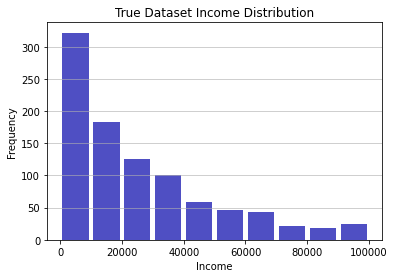

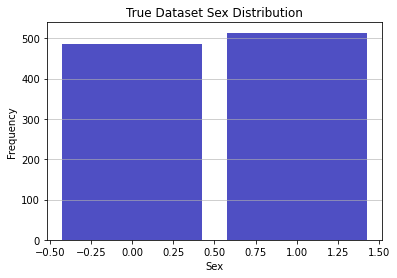

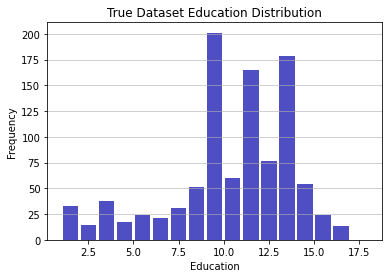

In [3]:
import matplotlib.pyplot as plt

data = np.genfromtxt(data_path, delimiter=',', names=True)
income = list(data[:]['income'])
sex = list(data[:]['sex'])
education = list(data[:]['educ'])

# An "interface" to matplotlib.axes.Axes.hist() method
n_income, bins, patches = plt.hist(income, bins=list(range(0,110000,10000)), color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Income')
plt.ylabel('Frequency')
plt.title('True Dataset Income Distribution')
plt.show()

n_sex, bins, patches = plt.hist(sex, bins=[-0.5,0.5,1.5], color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Sex')
plt.ylabel('Frequency')
plt.title('True Dataset Sex Distribution')
plt.show()

n_educ, bins, patches = plt.hist(education, bins=list(range(1,19,1)), color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Education')
plt.ylabel('Frequency')
plt.title('True Dataset Education Distribution')
plt.show()

Below we can see the differentially private releases of these variables in shades of red, against the "true" private counts in green.

[327 181 122 100  68  46  39  25  17  77]
[324.5909456  179.47165654 121.04845424 100.27398853  61.83390918
  45.14240425  50.02192732  15.59327888  16.46056665  75.6248959 ]


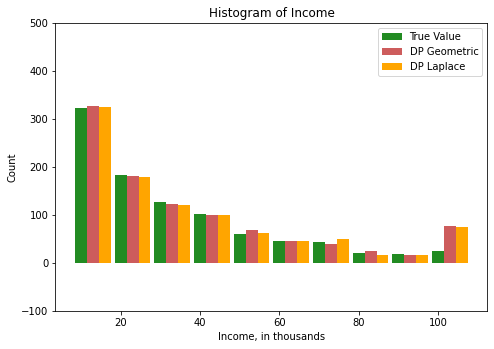

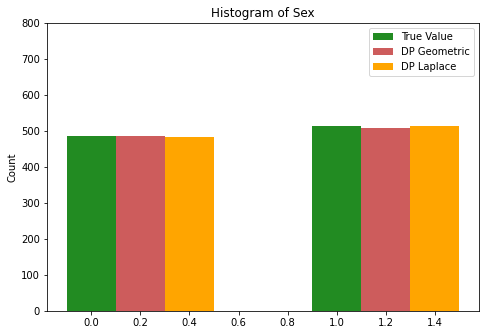

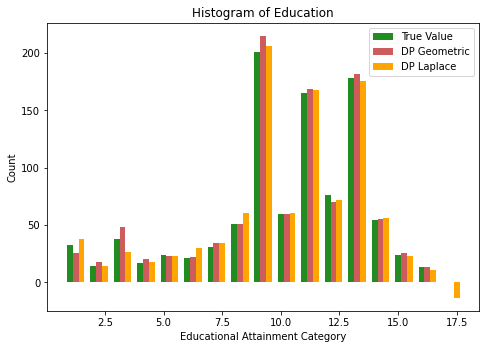

In [6]:
import matplotlib.pyplot as plt

colorseq = ["forestgreen", "indianred", "orange", "orangered", "orchid"]

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.ylim([-100,500])
#inccat = ["10k","20k","30k","40k","50k","60k","70k","80k","90k","100k"]
inccat = [10,20,30,40,50,60,70,80,90,100]
width=3
print(income_histogram.value)
print(income_histogram2.value)
inccat_left = [x + width for x in inccat]
inccat_right = [x + 2*width for x in inccat]
ax.bar(inccat, n_income, width=width, color=colorseq[0], label='True Value')
ax.bar(inccat_left, income_histogram.value, width=width, color=colorseq[1], label='DP Geometric')
ax.bar(inccat_right, income_histogram2.value, width=width, color=colorseq[2], label='DP Laplace')
ax.legend()
plt.title('Histogram of Income')
plt.xlabel('Income, in thousands')
plt.ylabel('Count')
plt.show()



fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.ylim([0,800])
sexcat = [0,1]
width = 0.2
sexcat_left = [x + width for x in sexcat]
sexcat_right = [x + 2*width for x in sexcat]
ax.bar(sexcat, n_sex, width=width, color=colorseq[0], label='True Value')
ax.bar(sexcat_left, sex_histogram.value, width=width, color=colorseq[1], label='DP Geometric')
ax.bar(sexcat_right, sex_histogram2.value, width=width, color=colorseq[2], label='DP Laplace')
ax.legend()
plt.title('Histogram of Sex')
plt.ylabel('Count')
plt.show()


fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
edcat = list(range(1,18))
width = 0.25
edcat_left = [x + width for x in edcat]
edcat_right = [x + 2*width for x in edcat]
ax.bar(edcat, n_educ, width=width, color=colorseq[0], label='True Value')
ax.bar(edcat_left, education_histogram.value, width=width, color=colorseq[1], label='DP Geometric')
ax.bar(edcat_right, education_histogram2.value, width=width, color=colorseq[2], label='DP Laplace')
ax.legend()
plt.title('Histogram of Education')
plt.xlabel('Educational Attainment Category')
plt.ylabel('Count')
plt.show()


## References

Mironov, Ilya. "On significance of the least significant bits for differential privacy." In Proceedings of the 2012 ACM conference on Computer and communications security, pp. 650-661. 2012.